In [1]:
# from .piplines import LoadImageFromFile, LoadAnnotations, Normalize, DefaultFormatBundle, Collect, TestCollect, Resize, Pad, RandomFlip, MultiScaleFlipAug, ImageToTensor

# process_funcs_dict = {'LoadImageFromFile':  LoadImageFromFile,
#                       'LoadAnnotations': LoadAnnotations,
#                       'Normalize': Normalize,
#                       'DefaultFormatBundle': DefaultFormatBundle,
#                       'Collect': Collect,
#                       'TestCollect': TestCollect,
#                       'Resize': Resize,
#                       'Pad': Pad,
#                       'RandomFlip': RandomFlip,
#                       'MultiScaleFlipAug': MultiScaleFlipAug, # This is only in testing anyways
#                       'ImageToTensor': ImageToTensor}

COLORS = ((244,  67,  54),
          (233,  30,  99),
          (156,  39, 176),
          (103,  58, 183),
          ( 63,  81, 181),
          ( 33, 150, 243),
          (  3, 169, 244),
          (  0, 188, 212),
          (  0, 150, 136),
          ( 76, 175,  80),
          (139, 195,  74),
          (205, 220,  57),
          (255, 235,  59),
          (255, 193,   7),
          (255, 152,   0),
          (255,  87,  34),
          (121,  85,  72),
          (158, 158, 158),
          ( 96, 125, 139))

# These are in RGB and are for ImageNet
MEANS = (123.675, 116.28, 123.675)
STD = (58.395, 57.12, 58.395)

# ----------------------- DATASETS ----------------------- #

DUMMY_CLASSES = ('circle', 'square')
DUMMY_LABEL_MAP = {1: 1, 2: 2}
DUMMY_LABEL = [1, 2]

class Config(object):
    """
    After implement this class, you can call 'cfg.x' instead of 'cfg['x']' to get a certain parameter.
    """

    def __init__(self, config_dict):
        for key, val in config_dict.items():
            self.__setattr__(key, val)

    def copy(self, new_config_dict={}):
        """
        Copies this config into a new config object, making the changes given by new_config_dict.
        """
        ret = Config(vars(self))
        for key, val in new_config_dict.items():
            ret.__setattr__(key, val)

        return ret

    def replace(self, new_config_dict):
        """
        Copies new_config_dict into this config object. Note: new_config_dict can also be a config object.
        """
        if isinstance(new_config_dict, Config):
            new_config_dict = vars(new_config_dict)

        for key, val in new_config_dict.items():
            self.__setattr__(key, val)

    def __repr__(self):
        return self.name
    
    def print(self):
        for k, v in vars(self).items():
            print(k, ' = ', v)

dummy = Config({
    'name': 'dummy',
    
    'train_prefix': './datasets/dummy_2d/imgs/',
    'train_info': 'imgs/annotations.json',
    'trainimg_prefix': '',
    'train_images': './datasets/dummy_2d/imgs/',

    'valid_prefix': './datasets/dummy_2d/',
    'valid_info': 'imgs/annotations.json',
    'validimg_prefix': './datasets/dummy_2d/imgs/',
    'valid_images': './datasets/dummy_2d/imgs/',

    'class_names': DUMMY_CLASSES,
    'label_map': DUMMY_LABEL_MAP,
    'label': DUMMY_LABEL,

    'num_classes': 3,
})

# ----------------------- BACKBONES ----------------------- #

resnet18_backbone = Config({
    'name': 'resnet18',
    'path': './pretrained/resnet18_nofc.pth',
    'type': 'ResNetBackbone',
    'num_stages': 4,
    'frozen_stages': 1,
    'out_indices': (0, 1, 2, 3)
})

#fpn config
fpn_base = Config({
    'in_channels': [64, 128, 256, 512],
    'out_channels': 256,
    'start_level': 0,
    'num_outs': 5,
})

# ----------------------- TRAIN PIPELINE ----------------------- #

train_pipeline = [
    dict(type='LoadImageFromFile'),                                 
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),     
    dict(type='Resize',                                             
        img_scale=[(768, 512), (768, 480), (768, 448),
                (768, 416), (768, 384), (768, 352)],
        multiscale_mode='value',
        keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),    
    dict(type='Normalize', mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True),                  
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'], 
                         meta_keys=('filename', 'ori_shape', 'img_shape', 'pad_shape', 'scale_factor', 'flip', 'img_norm_cfg')),   
]

# ----------------------- TRAIN CONFIG ----------------------- #

train_config = Config({
    'imgs_per_gpu': 16,
    'workers_per_gpu': 2,
    'num_gpus': 1,
    'train_pipeline': train_pipeline,
    'lr_config': dict(policy='step', warmup='linear', warmup_iters=500, warmup_ratio=0.01, step=[27, 33]),
    'optimizer': dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001),  
    'optimizer_config': dict(grad_clip=dict(max_norm=35, norm_type=2)),
    'total_epoch': 10,
    'epoch_iters_start': 1,
})

# ----------------------- TEST PIPELINE ----------------------- #

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(768, 448),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

# ----------------------- TEST CONFIG ----------------------- #

test_config = Config({
    'test_pipeline': test_pipeline,
    'test_cfg': dict(
                nms_pre=500,
                score_thr=0.1,
                mask_thr=0.5,
                update_thr=0.05,
                kernel='gaussian',  # gaussian/linear
                sigma=2.0,
                max_per_img=30)
})

# ----------------------- SOLO v2.0 CONFIGS ----------------------- #

solov2_base_config = dummy.copy({
    'name': 'solov2_base',
    'backbone': resnet18_backbone,
    'dataset': dummy,
    'train_config': train_config,
    'test_config': test_config,
})

cfg = solov2_base_config.copy()

def set_dataset(dataset_name:str):
    """ Sets the dataset of the current config. """
    cfg.dataset = eval(dataset_name)

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from PIL import Image

def visualize_sample(dataset_dir=None, split='train', sample_index=0):
    """
    Visualize dataset samples with annotations using matplotlib and numpy.
    Uses configuration from data.config.
    
    Args:
        dataset_dir: Path to the dataset directory (if None, uses cfg.dataset paths)
        split: 'train' or 'test'
        sample_index: Index of the sample to visualize
    """
    # Use dataset_dir from config if not provided
    if dataset_dir is None:
        if split == 'train':
            dataset_dir = os.path.dirname(os.path.dirname(cfg.dataset.train_prefix))
        else:
            dataset_dir = os.path.dirname(os.path.dirname(cfg.dataset.valid_prefix))
    
    # Load annotation data
    annotation_path = os.path.join(dataset_dir, cfg.dataset.valid_info)
    with open(annotation_path, 'r') as f:
        dataset_info = json.load(f)
    
    # Get category mapping from config
    categories = {i+1: name for i, name in enumerate(cfg.dataset.class_names)}
    
    # Get image directory based on split
    if split == 'test':
        img_dir = os.path.join(dataset_dir, 'test_imgs')
    else:
        img_dir = os.path.join(dataset_dir, 'imgs')
    
    # Get image files for the current split
    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
    
    if split == 'test':
        # For test images, we still need to get the image file name
        image_path = os.path.join(img_dir, image_files[sample_index % len(image_files)])
        image = np.array(Image.open(image_path))
        
        # Try to find image info and annotations in the dataset info
        image_info = None
        for img in dataset_info['images']:
            if img['file_name'] == os.path.basename(image_path):
                image_info = img
                break
                
        if image_info is None:
            # If not found, create a placeholder with the filename
            image_info = {'file_name': os.path.basename(image_path), 'id': -1}
    else:
        # Get image based on sample index for training set
        image_info = dataset_info['images'][sample_index]
        image_path = os.path.join(img_dir, image_info['file_name'])
        image = np.array(Image.open(image_path))
    
    # Find annotations for this image
    img_id = image_info['id']
    annotations = [ann for ann in dataset_info['annotations'] if ann['image_id'] == img_id]
    
    # Use colors from the config, and convert to matplotlib format (0-1 range)
    config_colors = {i+1: (r/255.0, g/255.0, b/255.0) for i, (r, g, b) in enumerate(COLORS)}
    
    # Generate random colors for instances based on instance ID
    instance_colors = {}
    for ann in annotations:
        # Use deterministic color based on instance ID, cycling through the COLORS array
        color_idx = ann['id'] % len(COLORS)
        instance_colors[ann['id']] = tuple(c/255.0 for c in COLORS[color_idx])
    
    # Create figure and axes
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Display original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title(f"{split.capitalize()} Image: {os.path.basename(image_path)}")
    axes[0, 0].axis('off')
    
    # Create a binary mask visualization
    binary_mask_ax = axes[0, 1]
    binary_mask_ax.imshow(np.zeros_like(image))
    binary_mask_ax.set_title("Binary Mask")
    binary_mask_ax.axis('off')
    
    # Create bounding box visualization
    bbox_ax = axes[0, 2]
    bbox_ax.imshow(image)
    bbox_ax.set_title("Bounding Boxes")
    bbox_ax.axis('off')
    
    # Create combined visualization
    combined_ax = axes[0, 3]
    combined_ax.imshow(image)
    combined_ax.set_title("Combined Visualization")
    combined_ax.axis('off')
    
    # Create instance segmentation visualization
    instance_ax = axes[1, 0]
    instance_ax.imshow(np.zeros_like(image))
    instance_ax.set_title("Instance Segmentation")
    instance_ax.axis('off')
    
    # Create class segmentation visualization
    class_ax = axes[1, 1]
    class_ax.imshow(np.zeros_like(image))
    class_ax.set_title("Class Segmentation")
    class_ax.axis('off')
    
    # Process annotations
    category_counts = {}
    for ann in annotations:
        # Get instance and class information
        instance_id = ann['id']
        category_id = ann['category_id']
        category_name = categories.get(category_id, f"Unknown-{category_id}")
        category_counts[category_id] = category_counts.get(category_id, 0) + 1
        
        # Get instance color
        instance_color = instance_colors[instance_id]
        
        # Get class color from the config colors
        class_color = config_colors.get(category_id, (0.0, 1.0, 0.0))
        
        # Process segmentation
        if 'segmentation' in ann and ann['segmentation']:
            segmentation_points = ann['segmentation'][0]  # First segmentation entry
            
            # Convert flat list to array of points
            points = []
            for i in range(0, len(segmentation_points), 2):
                if i+1 < len(segmentation_points):
                    x = segmentation_points[i]
                    y = segmentation_points[i+1]
                    points.append([x, y])
            
            # Convert to numpy array
            points = np.array(points)
            
            # Create polygon patches
            binary_poly = Polygon(points, facecolor='white', alpha=0.7)
            instance_poly = Polygon(points, facecolor=instance_color, alpha=0.7)
            class_poly = Polygon(points, facecolor=class_color, alpha=0.7)
            combined_poly = Polygon(points, facecolor=class_color, alpha=0.5)
            
            # Add polygons to respective axes
            binary_mask_ax.add_patch(binary_poly)
            instance_ax.add_patch(instance_poly)
            class_ax.add_patch(class_poly)
            combined_ax.add_patch(combined_poly)
        
        # Process bounding box
        if 'bbox' in ann:
            bbox = ann['bbox']
            x, y, w, h = bbox
            
            # Create rectangle patch for bounding box
            bbox_rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none')
            combined_rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none')
            
            # Add rectangle to bounding box visualization
            bbox_ax.add_patch(bbox_rect)
            combined_ax.add_patch(combined_rect)
            
            # Add label with class name and instance ID
            bbox_ax.text(x, y-5, f"{category_name} #{instance_id}", 
                         color='lime', fontsize=8, backgroundcolor='black')
            combined_ax.text(x, y-5, f"{category_name} #{instance_id}", 
                             color='lime', fontsize=8, backgroundcolor='black')
    
    # Create a legend for classes
    axes[1, 2].axis('off')
    axes[1, 2].set_title("Class Legend")
    for i, class_name in enumerate(cfg.dataset.class_names):
        cat_id = i + 1  # Category IDs are typically 1-indexed
        color = config_colors.get(cat_id, (0.0, 1.0, 0.0))
        axes[1, 2].add_patch(Rectangle((0.1, 0.7-i*0.3), 0.3, 0.2, color=color))
        axes[1, 2].text(0.5, 0.8-i*0.3, class_name, fontsize=12)
    
    # Add a panel showing annotation statistics
    axes[1, 3].axis('off')
    axes[1, 3].set_title("Annotation Statistics")
    stats_text = f"Total annotations: {len(annotations)}\n"
    
    for cat_id, count in category_counts.items():
        stats_text += f"{categories.get(cat_id, f'Unknown-{cat_id}')}: {count}\n"
    
    # Add dataset info
    stats_text += f"\nDataset: {cfg.dataset.name}\n"
    stats_text += f"Image size: {image.shape[1]}x{image.shape[0]}"
    
    axes[1, 3].text(0.1, 0.7, stats_text, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return annotations, categories

# Example usage:
# annotations, categories = visualize_sample()  # Uses config paths by default
# annotations, categories = visualize_sample(split='train', sample_index=45)  # Custom sample index

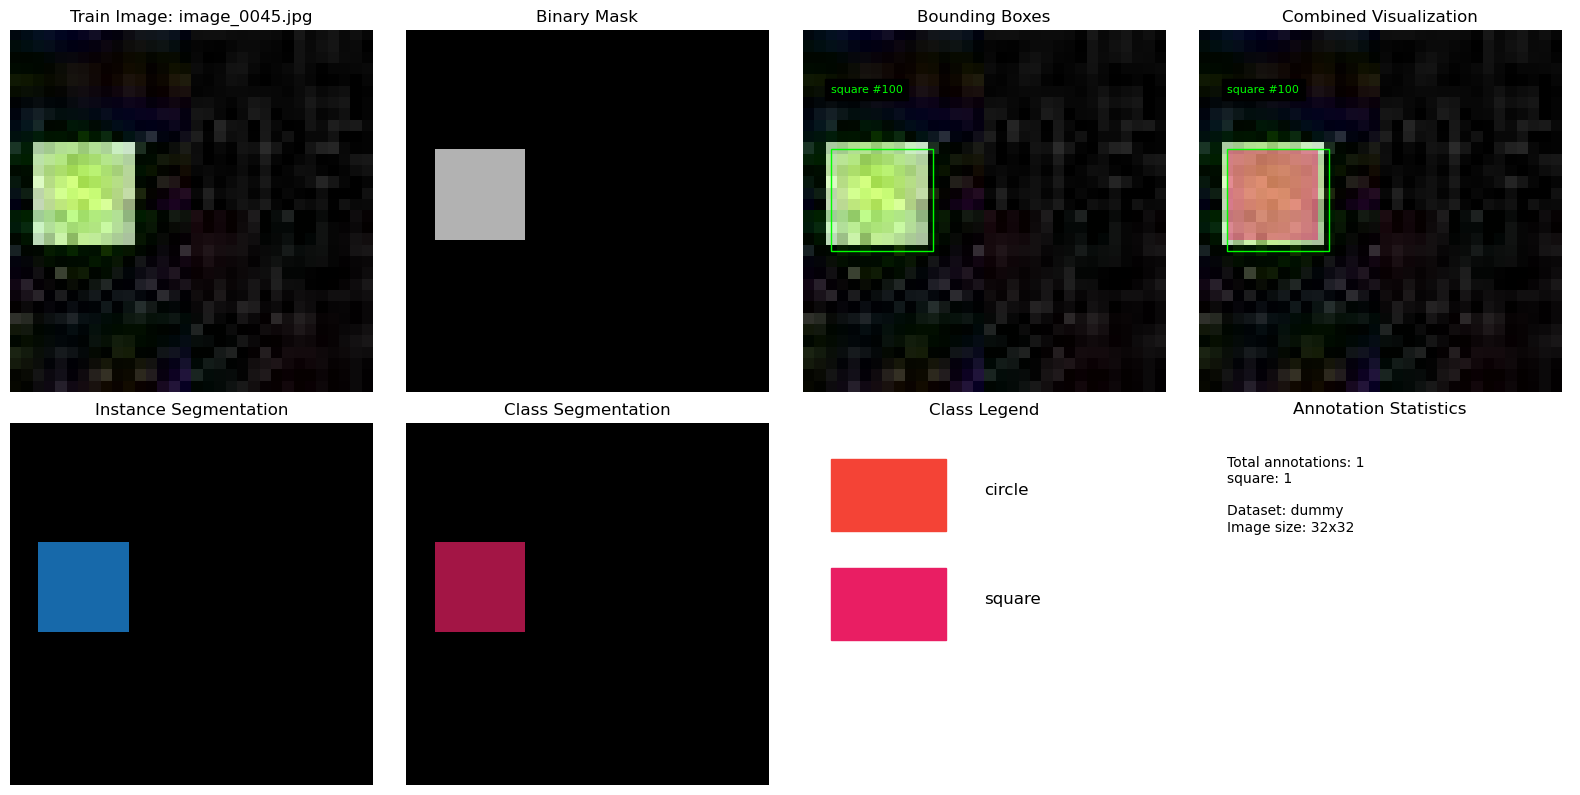

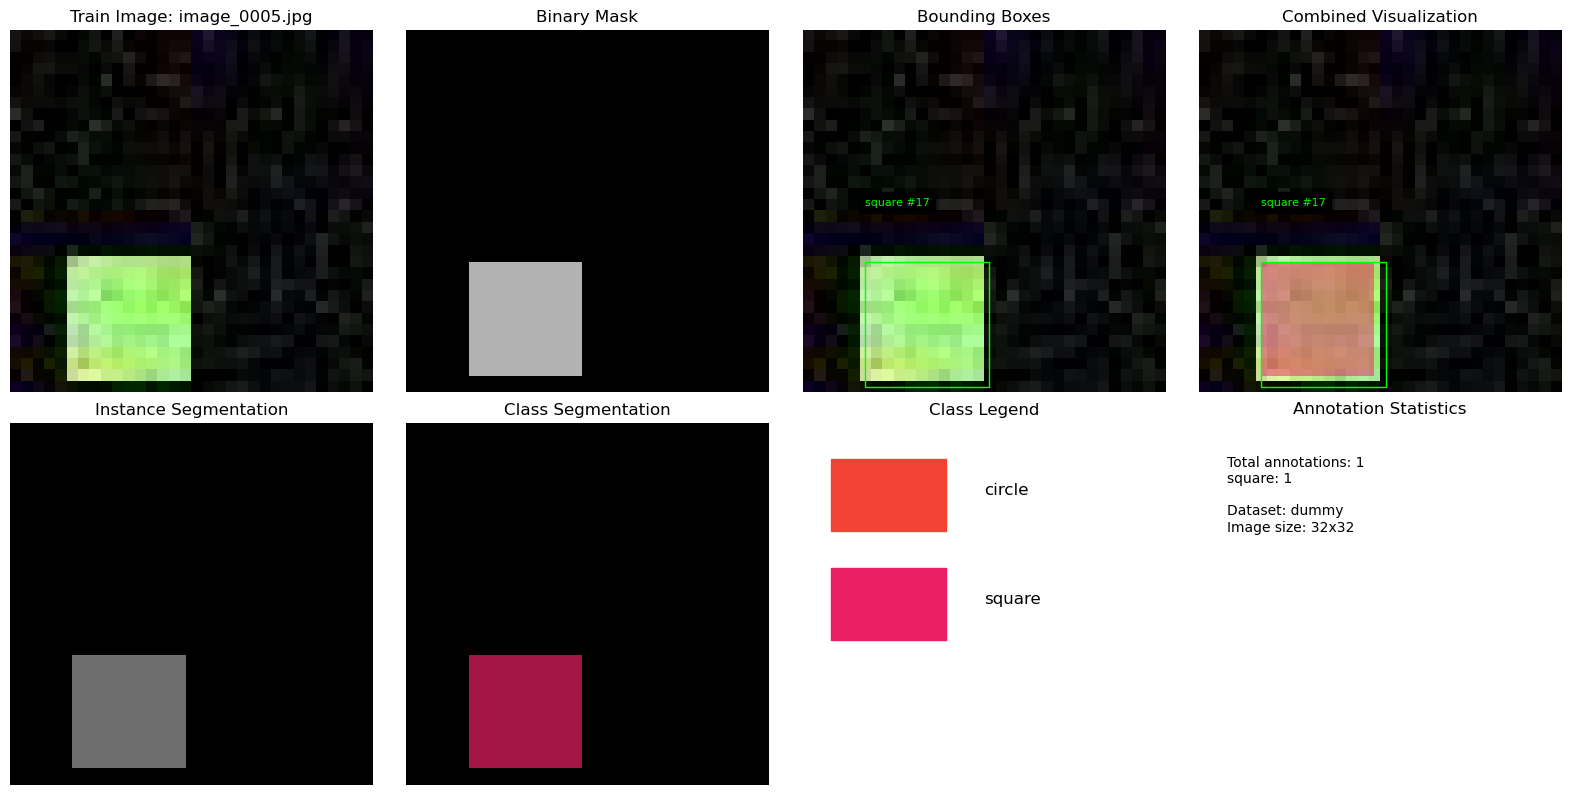

([{'id': 17,
   'image_id': 5,
   'category_id': 2,
   'segmentation': [[5.0, 20.0, 5.0, 30.0, 15.0, 30.0, 15.0, 20.0]],
   'area': 121.0,
   'bbox': [5.0, 20.0, 11.0, 11.0],
   'iscrowd': 0}],
 {1: 'circle', 2: 'square'})

In [3]:
# Example usage:
visualize_sample('/home/localssk23/SOLOv2_2D/datasets/dummy_2d', split='train', sample_index=45)
visualize_sample('/home/localssk23/SOLOv2_2D/datasets/dummy_2d', split='train', sample_index=5)

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from PIL import Image

def visualize_sample(dataset_dir=None, split='train', sample_index=18):
    """
    Visualize dataset samples with annotations using matplotlib and numpy.
    Uses configuration from data.config.
    
    Args:
        dataset_dir: Path to the dataset directory (if None, uses cfg.dataset paths)
        split: 'train' or 'test'
        sample_index: Index of the sample to visualize
    """
    # Use dataset_dir from config if not provided
    if dataset_dir is None:
        if split == 'train':
            dataset_dir = os.path.dirname(os.path.dirname(cfg.dataset.train_prefix))
        else:
            dataset_dir = os.path.dirname(os.path.dirname(cfg.dataset.valid_prefix))
    
    # Load annotation data
    annotation_path = os.path.join(dataset_dir, cfg.dataset.valid_info)
    with open(annotation_path, 'r') as f:
        dataset_info = json.load(f)
    
    # Get category mapping from config
    categories = {i+1: name for i, name in enumerate(cfg.dataset.class_names)}
    
    # Get image directory based on split
    if split == 'test':
        img_dir = os.path.join(dataset_dir, 'test_imgs')
    else:
        img_dir = os.path.join(dataset_dir, 'imgs')
    
    # Get image files for the current split
    image_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
    
    if split == 'test':
        # For test images, we still need to get the image file name
        image_path = os.path.join(img_dir, image_files[sample_index % len(image_files)])
        image = np.array(Image.open(image_path))
        
        # Try to find image info and annotations in the dataset info
        image_info = None
        for img in dataset_info['images']:
            if img['file_name'] == os.path.basename(image_path):
                image_info = img
                break
                
        if image_info is None:
            # If not found, create a placeholder with the filename
            image_info = {'file_name': os.path.basename(image_path), 'id': -1}
    else:
        # Get image based on sample index for training set
        image_info = dataset_info['images'][sample_index]
        image_path = os.path.join(img_dir, image_info['file_name'])
        image = np.array(Image.open(image_path))
    
    # Find annotations for this image
    img_id = image_info['id']
    annotations = [ann for ann in dataset_info['annotations'] if ann['image_id'] == img_id]
    
    # Use colors from the config, and convert to matplotlib format (0-1 range)
    config_colors = {i+1: (r/255.0, g/255.0, b/255.0) for i, (r, g, b) in enumerate(COLORS)}
    
    # Generate random colors for instances based on instance ID
    instance_colors = {}
    for ann in annotations:
        # Use deterministic color based on instance ID, cycling through the COLORS array
        color_idx = ann['id'] % len(COLORS)
        instance_colors[ann['id']] = tuple(c/255.0 for c in COLORS[color_idx])
    
    # Create figure and axes
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Display original image
    axes[0, 0].imshow(image)
    axes[0, 0].set_title(f"{split.capitalize()} Image: {os.path.basename(image_path)}")
    axes[0, 0].axis('off')
    
    # Create a binary mask visualization
    binary_mask_ax = axes[0, 1]
    binary_mask_ax.imshow(np.zeros_like(image))
    binary_mask_ax.set_title("Binary Mask")
    binary_mask_ax.axis('off')
    
    # Create bounding box visualization
    bbox_ax = axes[0, 2]
    bbox_ax.imshow(image)
    bbox_ax.set_title("Bounding Boxes")
    bbox_ax.axis('off')
    
    # Create combined visualization
    combined_ax = axes[0, 3]
    combined_ax.imshow(image)
    combined_ax.set_title("Combined Visualization")
    combined_ax.axis('off')
    
    # Create instance segmentation visualization
    instance_ax = axes[1, 0]
    instance_ax.imshow(np.zeros_like(image))
    instance_ax.set_title("Instance Segmentation")
    instance_ax.axis('off')
    
    # Create class segmentation visualization
    class_ax = axes[1, 1]
    class_ax.imshow(np.zeros_like(image))
    class_ax.set_title("Class Segmentation")
    class_ax.axis('off')
    
    # Process annotations
    category_counts = {}
    for ann in annotations:
        # Get instance and class information
        instance_id = ann['id']
        category_id = ann['category_id']
        category_name = categories.get(category_id, f"Unknown-{category_id}")
        category_counts[category_id] = category_counts.get(category_id, 0) + 1
        
        # Get instance color
        instance_color = instance_colors[instance_id]
        
        # Get class color from the config colors
        class_color = config_colors.get(category_id, (0.0, 1.0, 0.0))
        
        # Process segmentation
        if 'segmentation' in ann and ann['segmentation']:
            segmentation_points = ann['segmentation'][0]  # First segmentation entry
            
            # Convert flat list to array of points
            points = []
            for i in range(0, len(segmentation_points), 2):
                if i+1 < len(segmentation_points):
                    x = segmentation_points[i]
                    y = segmentation_points[i+1]
                    points.append([x, y])
            
            # Convert to numpy array
            points = np.array(points)
            
            # Create polygon patches
            binary_poly = Polygon(points, facecolor='white', alpha=0.7)
            instance_poly = Polygon(points, facecolor=instance_color, alpha=0.7)
            class_poly = Polygon(points, facecolor=class_color, alpha=0.7)
            combined_poly = Polygon(points, facecolor=class_color, alpha=0.5)
            
            # Add polygons to respective axes
            binary_mask_ax.add_patch(binary_poly)
            instance_ax.add_patch(instance_poly)
            class_ax.add_patch(class_poly)
            combined_ax.add_patch(combined_poly)
            
            # Calculate tight bounding box from points instead of using the provided one
            min_x = np.min(points[:, 0])
            min_y = np.min(points[:, 1])
            max_x = np.max(points[:, 0])
            max_y = np.max(points[:, 1])
            
            width = max_x - min_x
            height = max_y - min_y
            
            # Create rectangle patch for bounding box using the calculated dimensions
            bbox_rect = Rectangle((min_x, min_y), width, height, 
                                  linewidth=1, edgecolor='lime', facecolor='none')
            combined_rect = Rectangle((min_x, min_y), width, height, 
                                     linewidth=1, edgecolor='lime', facecolor='none')
            
            # Add rectangle to bounding box visualization
            bbox_ax.add_patch(bbox_rect)
            combined_ax.add_patch(combined_rect)
            
            # Add label with class name and instance ID
            bbox_ax.text(min_x, min_y-5, f"{category_name} #{instance_id}", 
                         color='lime', fontsize=8, backgroundcolor='black')
            combined_ax.text(min_x, min_y-5, f"{category_name} #{instance_id}", 
                             color='lime', fontsize=8, backgroundcolor='black')
        
        # If segmentation points aren't available but bbox is, use the bbox as provided
        elif 'bbox' in ann:
            bbox = ann['bbox']
            x, y, w, h = bbox
            
            # Create rectangle patch for bounding box
            bbox_rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none')
            combined_rect = Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none')
            
            # Add rectangle to bounding box visualization
            bbox_ax.add_patch(bbox_rect)
            combined_ax.add_patch(combined_rect)
            
            # Add label with class name and instance ID
            bbox_ax.text(x, y-5, f"{category_name} #{instance_id}", 
                         color='lime', fontsize=8, backgroundcolor='black')
            combined_ax.text(x, y-5, f"{category_name} #{instance_id}", 
                             color='lime', fontsize=8, backgroundcolor='black')
    
    # Create a legend for classes
    axes[1, 2].axis('off')
    axes[1, 2].set_title("Class Legend")
    for i, class_name in enumerate(cfg.dataset.class_names):
        cat_id = i + 1  # Category IDs are typically 1-indexed
        color = config_colors.get(cat_id, (0.0, 1.0, 0.0))
        axes[1, 2].add_patch(Rectangle((0.1, 0.7-i*0.3), 0.3, 0.2, color=color))
        axes[1, 2].text(0.5, 0.8-i*0.3, class_name, fontsize=12)
    
    # Add a panel showing annotation statistics
    axes[1, 3].axis('off')
    axes[1, 3].set_title("Annotation Statistics")
    stats_text = f"Total annotations: {len(annotations)}\n"
    
    for cat_id, count in category_counts.items():
        stats_text += f"{categories.get(cat_id, f'Unknown-{cat_id}')}: {count}\n"
    
    # Add dataset info
    stats_text += f"\nDataset: {cfg.dataset.name}\n"
    stats_text += f"Image size: {image.shape[1]}x{image.shape[0]}"
    
    axes[1, 3].text(0.1, 0.7, stats_text, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return annotations, categories

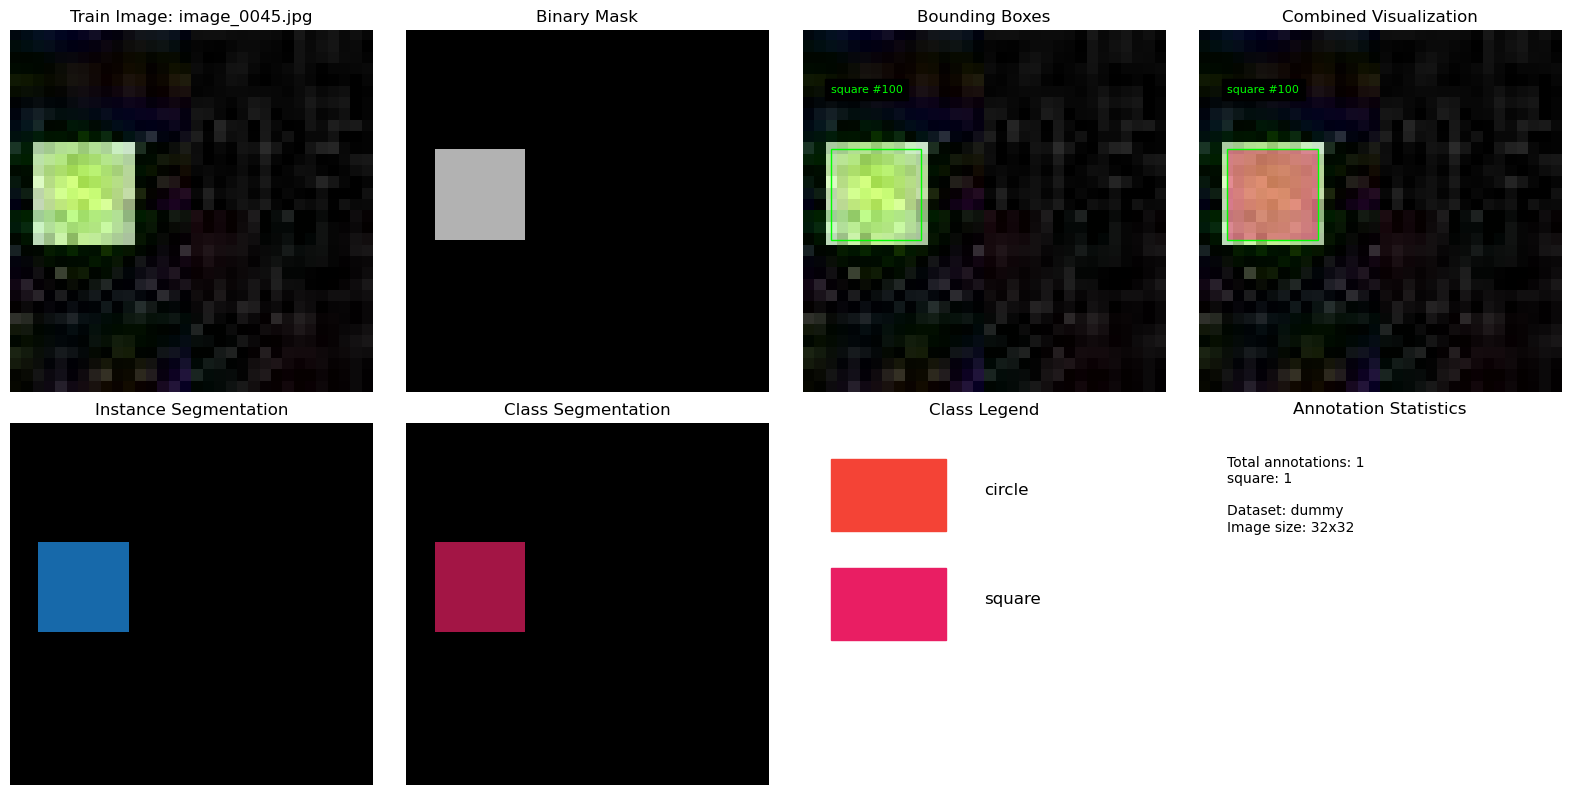

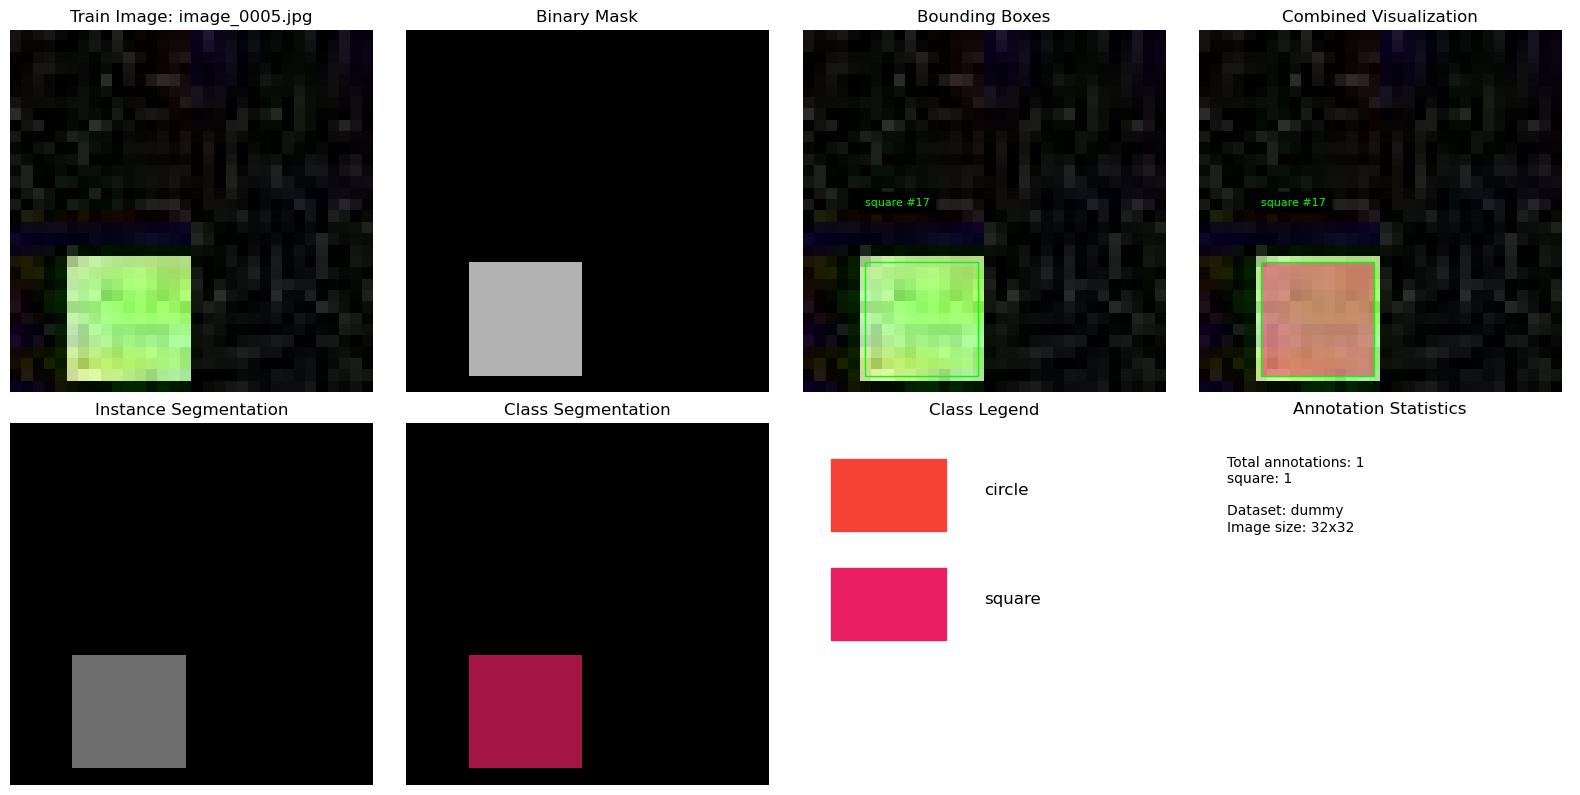

([{'id': 17,
   'image_id': 5,
   'category_id': 2,
   'segmentation': [[5.0, 20.0, 5.0, 30.0, 15.0, 30.0, 15.0, 20.0]],
   'area': 121.0,
   'bbox': [5.0, 20.0, 11.0, 11.0],
   'iscrowd': 0}],
 {1: 'circle', 2: 'square'})

In [5]:
# Example usage:
visualize_sample('/home/localssk23/SOLOv2_2D/datasets/dummy_2d', split='train', sample_index=45)
visualize_sample('/home/localssk23/SOLOv2_2D/datasets/dummy_2d', split='train', sample_index=5)